In [72]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import matplotlib.image as mpimg
from tqdm import tqdm
import nltk
import spacy
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

In [2]:
class Node:
  def __init__(self, feature = None, threshold = None, data_left = None , data_right = None, gain = None, value = None , gini = None):
    self.feature = feature
    self.threshold = threshold
    self.data_left = data_left
    self.data_right = data_right
    self.gain = gain
    self.value = value
    self.gini = gini

In [55]:
class DecisionTree:
    def __init__(self, min_samples_split=25, max_depth=100):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    @staticmethod
    def _entropy(s):
        counts = np.bincount(np.array(s, dtype=np.int64))
        percentages = counts / len(s)
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy

    def _information_gain(self, parent, left_child, right_child):
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))

    def _best_split(self, X, y):
        best_split = {}
        best_info_gain = -1
        best_gini = 1.0
        n_rows, n_cols = X.shape
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            thresholds = np.unique(X_curr)
            for threshold in thresholds:
                df_left = np.concatenate((X[X_curr <= threshold], y[X_curr <= threshold].reshape(-1, 1)), axis=1)
                df_right = np.concatenate((X[X_curr > threshold], y[X_curr > threshold].reshape(-1, 1)), axis=1)
                if len(df_left) > 0 and len(df_right) > 0:
                    y = np.concatenate((X, y.reshape(-1, 1)), axis=1)[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]
                    gain = self._information_gain(y, y_left, y_right)
                    gini = self._gini_index(X, y, f_idx, threshold)
                    if gini < best_gini:
                        best_gini = gini
                    #     best_feature = f_idx
                    #     best_threshold = threshold

                    # if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain,
                            'gini': gini
                        }
                        # best_info_gain = gain
        return best_split

    def _build(self, X, y, depth=0):
        n_rows, n_cols = X.shape
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            best = self._best_split(X, y)
            if best['gain'] > 0:
                left = self._build(
                    X=best['df_left'][:, :-1],
                    y=best['df_left'][:, -1],
                    depth=depth + 1
                )
                right = self._build(
                    X=best['df_right'][:, :-1],
                    y=best['df_right'][:, -1],
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'],
                    threshold=best['threshold'],
                    data_left=left,
                    data_right=right,
                    gain=best['gain']
                )
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )

    def _gini_impurity(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        gini = 1 - np.sum(probabilities ** 2)
        return gini


    def _gini_index(self, X, y, feature_index, threshold):
        left_indices = X[:, feature_index] <= threshold
        right_indices = X[:, feature_index] > threshold

        left_labels = y[left_indices]
        right_labels = y[right_indices]

        left_gini = self._gini_impurity(left_labels)
        right_gini = self._gini_impurity(right_labels)

        num_left = len(left_labels)
        num_right = len(right_labels)
        total_samples = num_left + num_right

        gini_index = (num_left / total_samples) * left_gini + (num_right / total_samples) * right_gini
        return gini_index


    def fit(self, X, y):
        self.root = self._build(X, y)

    def _predict(self, x, tree):
        if tree.value is not None:
            return tree.value
        feature_value = x[tree.feature]
        if feature_value <= tree.threshold:
            return self._predict(x, tree.data_left)
        if feature_value > tree.threshold:
            return self._predict(x, tree.data_right)

    def predict(self, X):
        return [self._predict(x, self.root) for x in X]

In [33]:
data = pd.read_csv('onlinefraud.csv')
print(data.shape)
print(data.head)
print(data.columns)


(100000, 10)
<bound method NDFrame.head of        step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0         1   PAYMENT    9839.64  C1231006815       170136.0       160296.36   
1         1   PAYMENT    1864.28  C1666544295        21249.0        19384.72   
2         1  TRANSFER     181.00  C1305486145          181.0            0.00   
3         1  CASH_OUT     181.00   C840083671          181.0            0.00   
4         1   PAYMENT   11668.14  C2048537720        41554.0        29885.86   
...     ...       ...        ...          ...            ...             ...   
99995    10   PAYMENT    4020.66  C1410794718       159929.0       155908.34   
99996    10   PAYMENT   18345.49   C744303677         6206.0            0.00   
99997    10   CASH_IN  183774.91   C104331851        39173.0       222947.91   
99998    10  CASH_OUT   82237.17   C707662966         6031.0            0.00   
99999    10   PAYMENT   20096.56  C1868032458       110117.0        90020.44 

In [56]:
columns_to_convert = ['type','nameOrig','nameDest']
label_encoder = LabelEncoder()

for column in columns_to_convert:
    data[column] = label_encoder.fit_transform(data[column])

In [58]:
def run_model_and_get_accuracy(X, y):
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X_imputed.values, y.values, test_size=0.25, random_state=42)
    sk_model = DecisionTreeClassifier()
    sk_model.fit(X_train, y_train)
    sk_preds = sk_model.predict(X_test)

    return accuracy_score(y_test, sk_preds)

accuracy_scores = []

for i in range(1, 97):
    accuracy = run_model_and_get_accuracy(X, y)
    accuracy_scores.append(accuracy)
    print(f"Iteration = {i} => Accuracy = {accuracy}")

Iteration = 1 => Accuracy = 0.9488888888888889
Iteration = 2 => Accuracy = 0.9497777777777778
Iteration = 3 => Accuracy = 0.9502222222222222
Iteration = 4 => Accuracy = 0.9484444444444444
Iteration = 5 => Accuracy = 0.9533333333333334
Iteration = 6 => Accuracy = 0.9506666666666667
Iteration = 7 => Accuracy = 0.9497777777777778
Iteration = 8 => Accuracy = 0.9484444444444444
Iteration = 9 => Accuracy = 0.9502222222222222
Iteration = 10 => Accuracy = 0.9511111111111111
Iteration = 11 => Accuracy = 0.9528888888888889
Iteration = 12 => Accuracy = 0.9488888888888889
Iteration = 13 => Accuracy = 0.9475555555555556
Iteration = 14 => Accuracy = 0.9506666666666667
Iteration = 15 => Accuracy = 0.9502222222222222
Iteration = 16 => Accuracy = 0.9484444444444444
Iteration = 17 => Accuracy = 0.948
Iteration = 18 => Accuracy = 0.9475555555555556
Iteration = 19 => Accuracy = 0.9511111111111111
Iteration = 20 => Accuracy = 0.9511111111111111
Iteration = 21 => Accuracy = 0.9497777777777778
Iteration = 22

In [59]:
max_index = np.argmax(accuracy_scores)
max_acc = accuracy_scores[max_index]

print("\nOptimal iteration:", max_index + 1)
print("Maximum Accuracy:", max_acc*100)


Optimal iteration: 5
Maximum Accuracy: 95.33333333333334


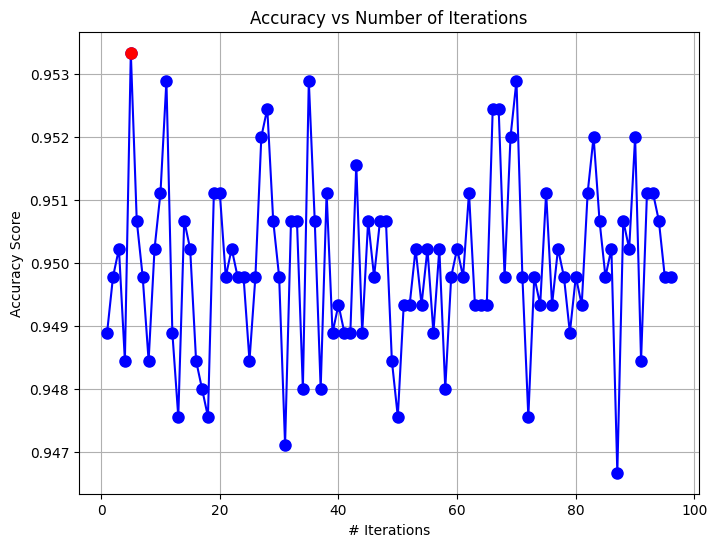

In [69]:
plt.figure(figsize=(8, 6))
x_values = list(range(1, 97))
y_values = accuracy_scores
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', markersize=8)


max_accuracy_index = np.argmax(accuracy_scores)
max_accuracy = max(accuracy_scores)
plt.plot(max_accuracy_index + 1, max_accuracy, marker='o', markersize=8, color='r')

plt.title("Accuracy vs Number of Iterations")
plt.xlabel("# Iterations")
plt.ylabel("Accuracy Score")
plt.grid(True)
plt.show()




In [70]:
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
dot_data = export_graphviz(model, out_file=None, feature_names=iris.feature_names, class_names=iris.target_names, filled=True, rounded=True)

graph = graphviz.Source(dot_data)
graph.render("result", format="png", cleanup=True)
graph.view()

'result.pdf'

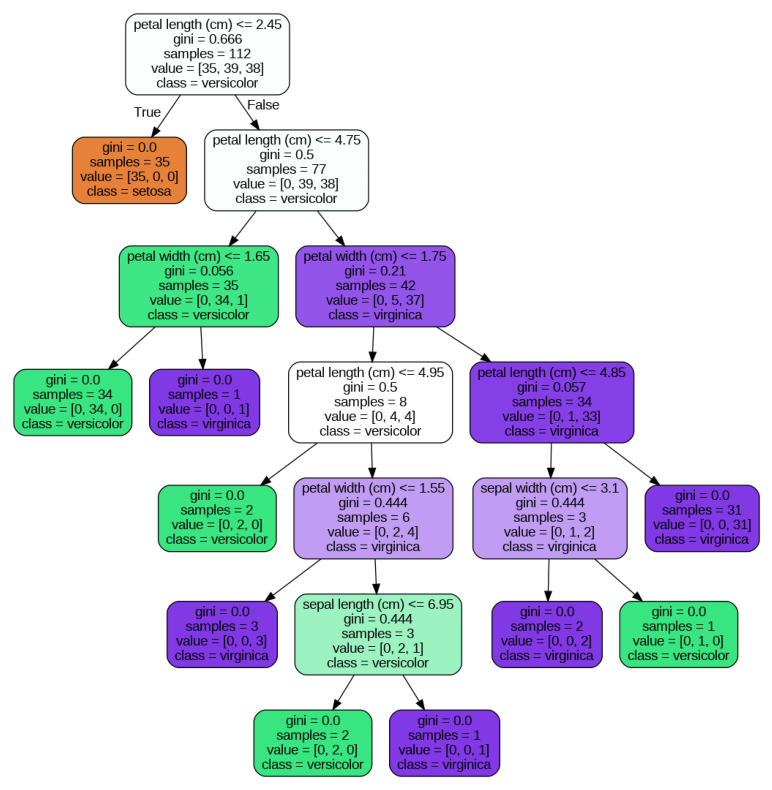

In [73]:
image_path = "result.png"

img = mpimg.imread(image_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [65]:
model = DecisionTree()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [66]:
accuracy_score(y_test, preds)

0.9736842105263158